<h3>NYC Yellow Cab: Processing Large Datasets</h3>

<h3>Data Acquisition and Preprocessing</h3>

In [7]:
#pip install --upgrade pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 5.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
Note: you may need to restart the kernel to use updated packages.


In [1]:
#import libraries
import requests
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

<h4>Collect and Load Dataset</h4>

In [2]:
# Load the data
df = pd.read_parquet('yellow_tripdata_2024-01.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [3]:
#check for null values
df.isnull().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          140162
trip_distance                 0
RatecodeID               140162
store_and_fwd_flag       140162
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     140162
Airport_fee              140162
dtype: int64

<h4>Data Cleaning and Formatting</h4>

In [5]:
# Function for cleaning
def clean_data(df):
    # Handle missing values
    df['passenger_count'].fillna(df['passenger_count'].mode()[0], inplace=True)
    df.dropna(subset=['RatecodeID', 'store_and_fwd_flag', 'congestion_surcharge', 'Airport_fee'], inplace=True)
    
    # Remove invalid fares/distances
    df = df[df['fare_amount'] > 0]
    df = df[df['trip_distance'] > 0]
    df = df[df['trip_distance'] < 100]
    
    # Remove duplicates
    df.drop_duplicates(inplace=True)
    
    # Convert datetimes
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    
    # Trip duration and remove outliers
    df['trip_duration_minutes'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
    df = df[(df['trip_duration_minutes'] > 1) & (df['trip_duration_minutes'] < 180)]
    
    # Basic location validation (zones 1-263)
    df = df[(df['PULocationID'].between(1, 263)) & (df['DOLocationID'].between(1, 263))]

    #optimize data type
    df['store_and_fwd_flag'] = df['store_and_fwd_flag'].astype('category')

    #Time-based columns for analysis
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
    df['pickup_dayofweek'] = df['tpep_pickup_datetime'].dt.day_name()

    #Total revenue column
    df['total_revenue'] = df['fare_amount'] + df['tip_amount'] + df['tolls_amount']
    
    print("Cleaned shape:", df.shape)
    return df

cleaned_df = clean_data(df.copy())
df.describe()

Cleaned shape: (2716925, 23)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,2.964624e+06,2964624,2964624,2.824462e+06,2.964624e+06,2.824462e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.824462e+06,2.824462e+06
mean,1.754204e+00,2024-01-17 00:46:36.431092,2024-01-17 01:02:13.208130,1.339281e+00,3.652169e+00,2.069359e+00,1.660179e+02,1.651167e+02,1.161271e+00,1.817506e+01,1.451598e+00,4.833823e-01,3.335870e+00,5.270212e-01,9.756319e-01,2.680150e+01,2.256122e+00,1.411611e-01
min,1.000000e+00,2002-12-31 22:59:39,2002-12-31 23:05:41,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-8.990000e+02,-7.500000e+00,-5.000000e-01,-8.000000e+01,-8.000000e+01,-1.000000e+00,-9.000000e+02,-2.500000e+00,-1.750000e+00
25%,2.000000e+00,2024-01-09 15:59:19.750000,2024-01-09 16:16:23,1.000000e+00,1.000000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.538000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2024-01-17 10:45:37.500000,2024-01-17 11:03:51.500000,1.000000e+00,1.680000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.700000e+00,0.000000e+00,1.000000e+00,2.010000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2024-01-24 18:23:52.250000,2024-01-24 18:40:29,1.000000e+00,3.110000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.050000e+01,2.500000e+00,5.000000e-01,4.120000e+00,0.000000e+00,1.000000e+00,2.856000e+01,2.500000e+00,0.000000e+00
max,6.000000e+00,2024-02-01 00:01:15,2024-02-02 13:56:52,9.000000e+00,3.127223e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,5.000000e+03,1.425000e+01,4.000000e+00,4.280000e+02,1.159200e+02,1.000000e+00,5.000000e+03,2.500000e+00,1.750000e+00
std,4.325902e-01,NaN,NaN,8.502817e-01,2.254626e+02,9.823219e+00,6.362391e+01,6.931535e+01,5.808686e-01,1.894955e+01,1.804102e+00,1.177600e-01,3.896551e+00,2.128310e+00,2.183645e-01,2.338558e+01,8.232747e-01,4.876239e-01


In [20]:
# Display cleaned data info
print("\nCleaned DataFrame Info:")
df.info()
print("\nFirst 5 rows of the cleaned dataset:")
print(df.head())


Cleaned DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 2824462 entries, 0 to 2824461
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Ai

<h4>Data Storage</h4>

In [6]:
# Save cleaned data to Parquet
output_file = 'yellow_tripdata_2024-01_cleaned.parquet'
cleaned_df.to_parquet(output_file, engine='fastparquet', compression='snappy')
print(f"Saved to {output_file}")

Saved to yellow_tripdata_2024-01_cleaned.parquet


<h3>Data Processing and Analysis</h3>

In [7]:
#ETL Pipeline
def etl_pipeline(input_file, output_file):
    # Extract
    print("Extracting...")
    df = pd.read_parquet(input_file)
    
    # Transform
    print("Transforming...")
    cleaned_df = clean_data(df)
    
    # Load
    print("Loading...")
    cleaned_df.to_parquet(output_file, engine='fastparquet', compression='snappy')
    
    print("ETL done!")
    return cleaned_df

# Run ETL
final_df = etl_pipeline('yellow_tripdata_2024-01.parquet', 'yellow_tripdata_2024-01_processed.parquet')

Extracting...
Transforming...
Cleaned shape: (2716925, 23)
Loading...
ETL done!


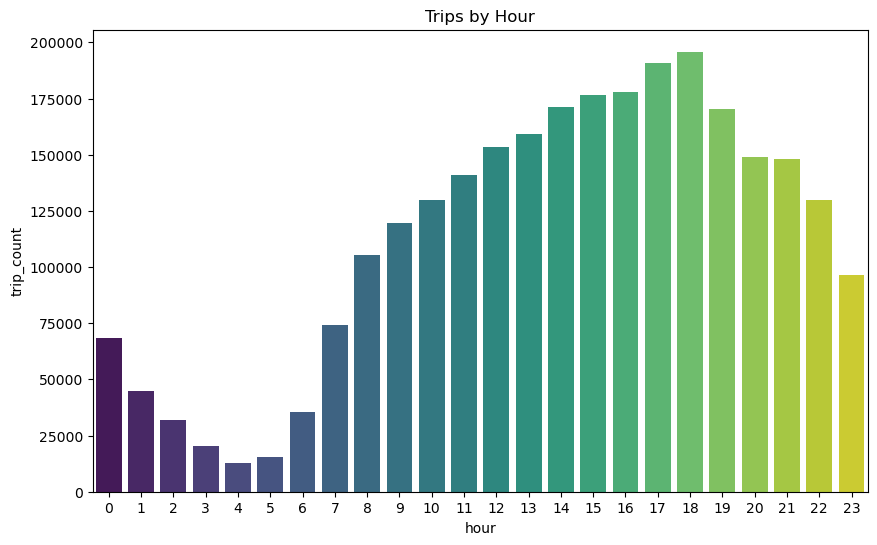

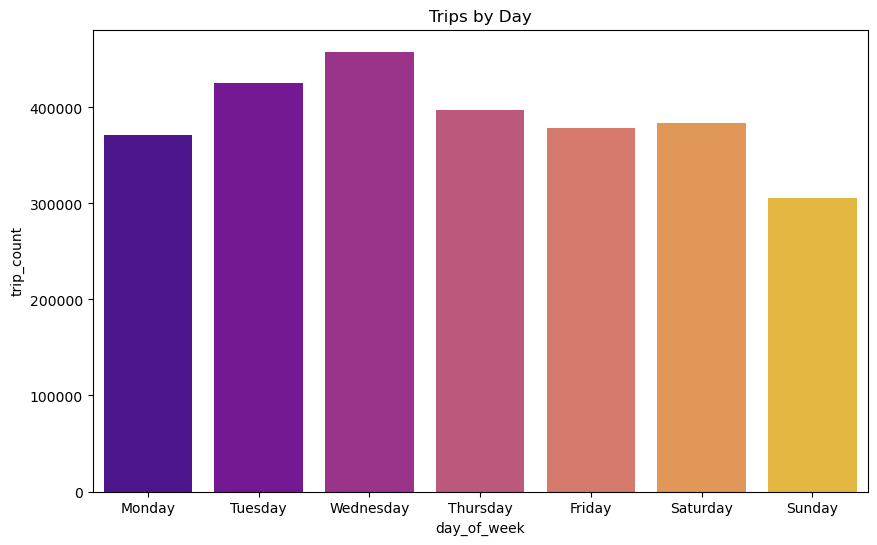

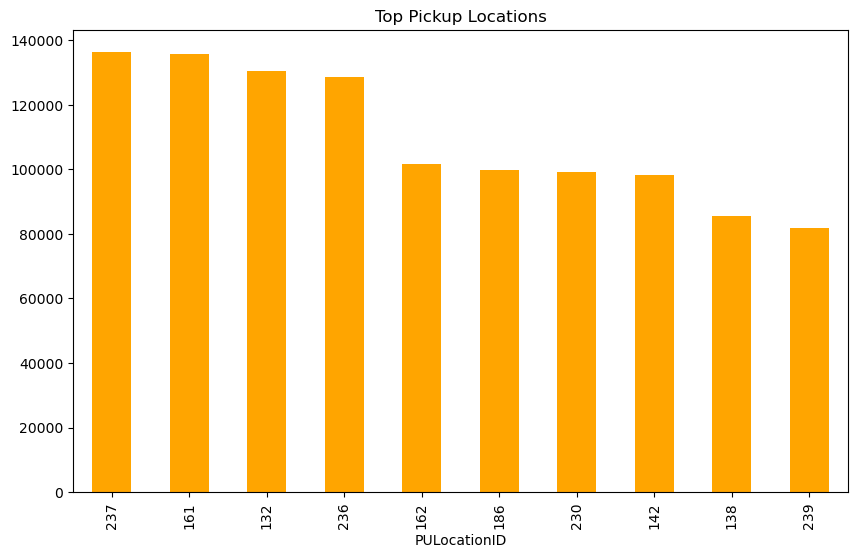

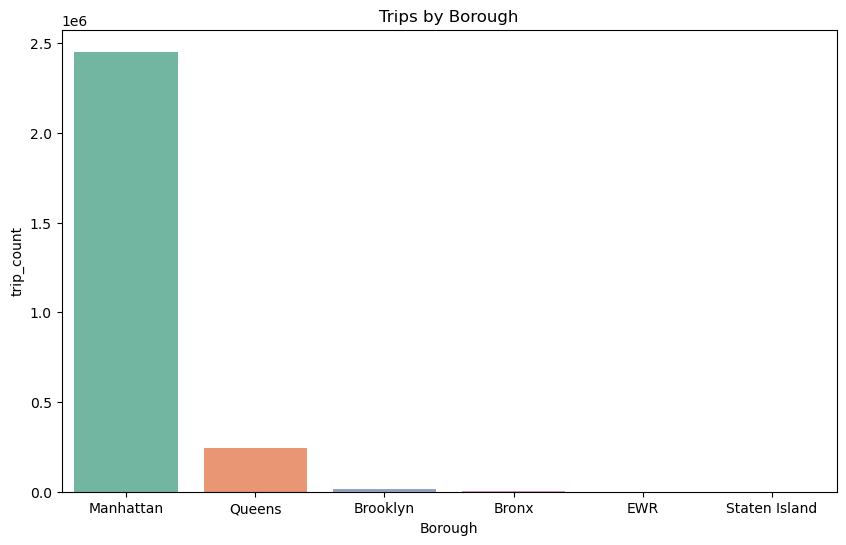

In [8]:
#trip pattern and demand analysis

# Add features
final_df['hour'] = cleaned_df['tpep_pickup_datetime'].dt.hour
final_df['day_of_week'] = cleaned_df['tpep_pickup_datetime'].dt.day_name()

# 1. Peak travel time by hour
hourly_trips = final_df.groupby('hour').size().reset_index(name='trip_count')
plt.figure(figsize=(10, 6))
sns.barplot(x='hour', y='trip_count', data=hourly_trips, palette='viridis')
plt.title('Trips by Hour')
plt.savefig('hourly_trips.png')
plt.show()

# 2. Peak travel time by day
daily_trips = final_df.groupby('day_of_week').size().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index(name='trip_count')
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='trip_count', data=daily_trips, palette='plasma')
plt.title('Trips by Day')
plt.savefig('daily_trips.png')
plt.show()

# 3. High-demand pickup locations
top_pickups = final_df['PULocationID'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_pickups.plot(kind='bar', color='orange')
plt.title('Top Pickup Locations')
plt.savefig('top_pickups.png')
plt.show()

# Geospatial analysis by borough
zone_url = 'https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/taxi-zone-lookup.csv'
zone_df = pd.read_csv(zone_url)
zone_df.columns = ['LocationID', 'Borough', 'Zone']

# Merge and group
pickup_borough = final_df.merge(zone_df[['LocationID', 'Borough']], left_on='PULocationID', right_on='LocationID')
borough_trips = pickup_borough.groupby('Borough').size().reset_index(name='trip_count').sort_values('trip_count', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Borough', y='trip_count', data=borough_trips, palette='Set2')
plt.title('Trips by Borough')
plt.savefig('borough_trips.png')
plt.show()

<h4>Fare and revenue analysis</h4>

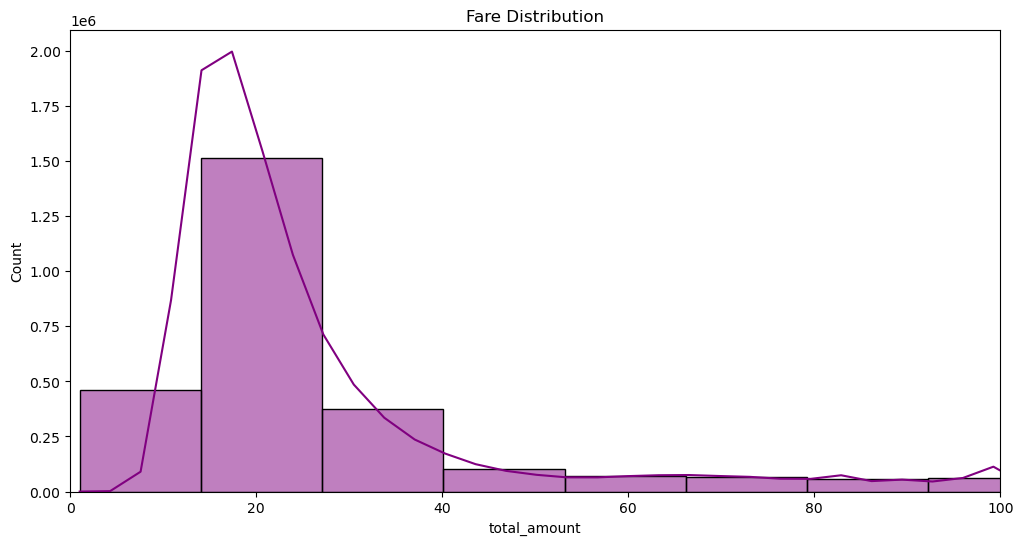

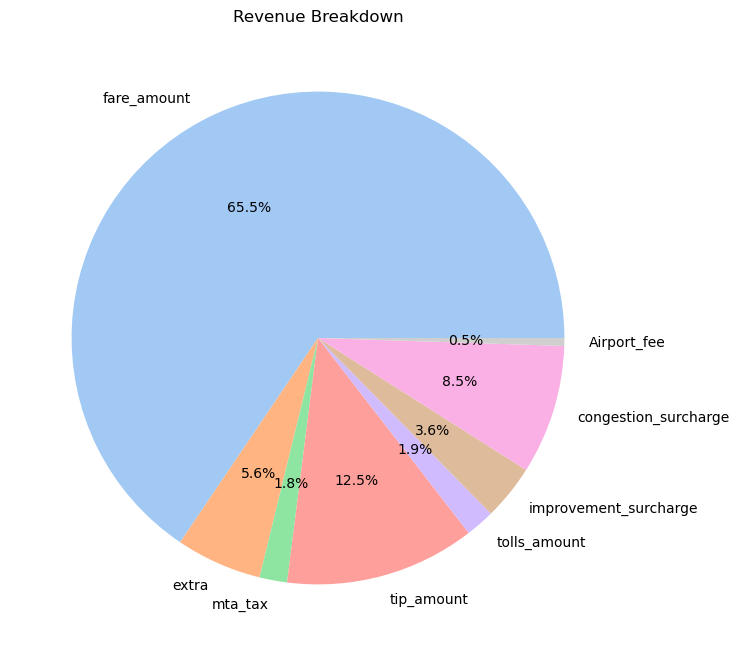

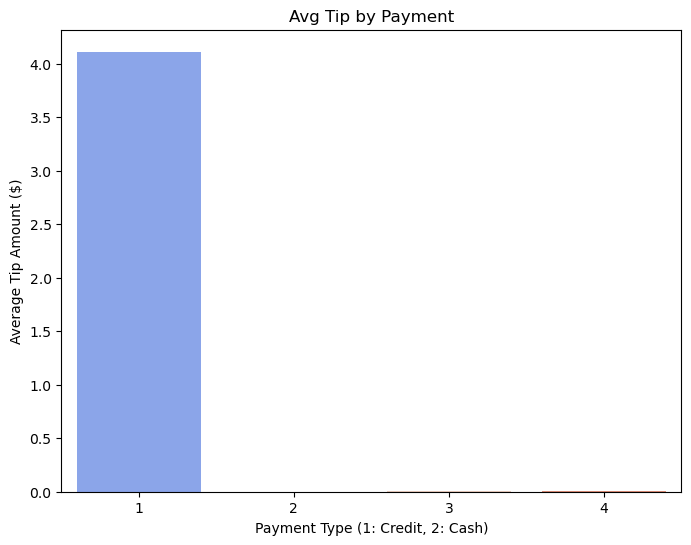

Avg revenue per mile: 13.458156680705002


In [10]:
# 1. Fare distribution
plt.figure(figsize=(12, 6))
sns.histplot(cleaned_df['total_amount'], bins=50, kde=True, color='purple')
plt.title('Fare Distribution')
plt.xlim(0, 100)
plt.savefig('fare_dist.png')
plt.show()

# 2. Revenue breakdown
revenue_cols = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']
revenue_totals = cleaned_df[revenue_cols].sum()
plt.figure(figsize=(10, 8))
plt.pie(revenue_totals, labels=revenue_totals.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Revenue Breakdown')
plt.savefig('revenue_breakdown.png')
plt.show()

# 3. Avg tip by payment type
avg_tip = cleaned_df.groupby('payment_type')['tip_amount'].mean()
plt.figure(figsize=(8, 6))
sns.barplot(x=avg_tip.index, y=avg_tip.values, palette='coolwarm')
plt.title('Avg Tip by Payment')
plt.xlabel('Payment Type (1: Credit, 2: Cash)')
plt.ylabel('Average Tip Amount ($)')
plt.savefig('avg_tip.png')
plt.show()

# 4.Profitability analysis
final_df['revenue_per_mile'] = final_df['total_amount'] / final_df['trip_distance']
print("Avg revenue per mile:", final_df['revenue_per_mile'].mean())